# Track Embeddings with Word2Vec


In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')


## Load Data


In [2]:
DATA_PATH = Path.home() / ".cache/kagglehub/datasets/himanshuwagh/spotify-million/versions/1/data"

slice_files = sorted(DATA_PATH.glob("mpd.slice.*.json"))
print(f"Found {len(slice_files)} slice files")

all_playlists = []
for slice_file in slice_files:
    with open(slice_file) as f:
        data = json.load(f)
        all_playlists.extend(data["playlists"])

print(f"Total playlists: {len(all_playlists):,}")


Found 19 slice files
Total playlists: 19,000


## Prepare Training Data


In [3]:
playlist_sequences = []
track_info = {}

for playlist in all_playlists:
    track_ids = []
    for track in playlist['tracks']:
        track_uri = track['track_uri']
        track_ids.append(track_uri)
        if track_uri not in track_info:
            track_info[track_uri] = {
                'track_name': track['track_name'],
                'artist_name': track['artist_name'],
                'album_name': track['album_name'],
                'artist_uri': track['artist_uri'],
                'album_uri': track['album_uri'],
                'duration_ms': track['duration_ms']
            }
    if len(track_ids) >= 5:
        playlist_sequences.append(track_ids)

print(f"Playlists for training: {len(playlist_sequences):,}")
print(f"Unique tracks: {len(track_info):,}")
print(f"Avg playlist length: {np.mean([len(p) for p in playlist_sequences]):.1f}")


Playlists for training: 19,000
Unique tracks: 252,999
Avg playlist length: 67.0


In [4]:
track_df = pd.DataFrame.from_dict(track_info, orient='index')
track_df.index.name = 'track_uri'
track_df = track_df.reset_index()
print(f"Track metadata shape: {track_df.shape}")
track_df.head()


Track metadata shape: (252999, 7)


,track_uri,track_name,artist_name,album_name,artist_uri,album_uri,duration_ms
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),Missy Elliott,The Cookbook,spotify:artist:2wIVse2owClT7go1WT98tk,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863
1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Toxic,Britney Spears,In The Zone,spotify:artist:26dSoYclwsYLMAKD3tpOr4,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800
2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,Beyoncé,Dangerously In Love (Alben für die Ewigkeit),spotify:artist:6vWDO969PvNqNYHIOW5v0m,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933
3,spotify:track:1AWQoqb9bSvzTjaLralEkT,Rock Your Body,Justin Timberlake,Justified,spotify:artist:31TPClRtHm23RisEBtV3X7,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266
4,spotify:track:1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,Shaggy,Hot Shot,spotify:artist:5EvFsr3kj42KNv97ZEnqij,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600


## Train Word2Vec Model


In [5]:
EMBEDDING_DIM = 128
WINDOW_SIZE = 10
MIN_COUNT = 3
WORKERS = 4
EPOCHS = 10

model = Word2Vec(
    sentences=playlist_sequences,
    vector_size=EMBEDDING_DIM,
    window=WINDOW_SIZE,
    min_count=MIN_COUNT,
    workers=WORKERS,
    epochs=EPOCHS,
    sg=1,
    negative=10,
    seed=42
)

print(f"Vocabulary size: {len(model.wv):,}")
print(f"Embedding dimension: {model.wv.vector_size}")


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Vocabulary size: 62,476
Embedding dimension: 128


## Test Embeddings


In [6]:
def get_track_display(track_uri):
    if track_uri in track_info:
        t = track_info[track_uri]
        return f"{t['track_name']} - {t['artist_name']}"
    return track_uri

def find_similar_tracks(track_uri, topn=10):
    if track_uri not in model.wv:
        print(f"Track not in vocabulary: {track_uri}")
        return []
    similar = model.wv.most_similar(track_uri, topn=topn)
    results = []
    for uri, score in similar:
        results.append({
            'track': get_track_display(uri),
            'similarity': round(score, 4)
        })
    return pd.DataFrame(results)


In [7]:
sample_tracks = track_df.sample(5, random_state=42)
for _, row in sample_tracks.iterrows():
    track_uri = row['track_uri']
    if track_uri in model.wv:
        print(f"\nQuery: {row['track_name']} - {row['artist_name']}")
        print("-" * 50)
        display(find_similar_tracks(track_uri, topn=5))



Query: H•A•M - Kanye West
--------------------------------------------------


,track,similarity
0,That's My Bitch - JAY Z,0.9407
1,Cold - Kanye West,0.9339
2,Illest Motherf**ker Alive - JAY Z,0.9250
3,New Day - JAY Z,0.9187
4,Murder To Excellence - JAY Z,0.9178



Query: Raiders March - John Williams
--------------------------------------------------


,track,similarity
0,Back To The Future: Back To The Future - Alan ...,0.9680
1,"Theme From Jurassic Park - From The ""Jurassic ...",0.9612
2,Autobots - Steve Jablonsky,0.9607
3,Overture - Andrew Lloyd Webber,0.9578
4,Mission Impossible - The Session,0.9543



Query: Y U DON'T LOVE ME? (MISS AMERIKKKA) - Joey Bada$$
--------------------------------------------------


,track,similarity
0,SUPER PREDATOR (feat. Styles P) - Joey Bada$$,0.9925
1,GOOD MORNING AMERIKKKA - Joey Bada$$,0.9904
2,BABYLON (feat. Chronixx) - Joey Bada$$,0.9788
3,AMERIKKKAN IDOL - Joey Bada$$,0.9715
4,"RING THE ALARM (feat. Nyck Caution, Kirk Knigh...",0.9606


## Popular Track Similarity Test


In [8]:
track_counts = defaultdict(int)
for seq in playlist_sequences:
    for track in seq:
        track_counts[track] += 1

popular_tracks = sorted(track_counts.items(), key=lambda x: -x[1])[:20]
print("Top 20 most popular tracks:")
for uri, count in popular_tracks:
    print(f"  {count:5d} | {get_track_display(uri)}")


Top 20 most popular tracks:
    878 | One Dance - Drake
    875 | HUMBLE. - Kendrick Lamar
    808 | Closer - The Chainsmokers
    803 | Broccoli (feat. Lil Yachty) - DRAM
    770 | Congratulations - Post Malone
    717 | iSpy (feat. Lil Yachty) - KYLE
    704 | Caroline - Aminé
    693 | Location - Khalid
    689 | XO TOUR Llif3 - Lil Uzi Vert
    666 | No Role Modelz - J. Cole
    665 | Bounce Back - Big Sean
    662 | Bad and Boujee (feat. Lil Uzi Vert) - Migos
    642 | No Problem (feat. Lil Wayne & 2 Chainz) - Chance The Rapper
    632 | Jumpman - Drake
    621 | goosebumps - Travis Scott
    611 | Mask Off - Future
    609 | Roses - The Chainsmokers
    609 | Fake Love - Drake
    598 | I'm the One - DJ Khaled
    597 | Don't Let Me Down - The Chainsmokers


In [9]:
top_track_uri = popular_tracks[0][0]
print(f"Similar to: {get_track_display(top_track_uri)}\n")
find_similar_tracks(top_track_uri, topn=10)


Similar to: One Dance - Drake



,track,similarity
0,Too Good - Drake,0.7553
1,Controlla - Drake,0.7365
2,Pop Style - Drake,0.7200
3,Don't Mind - Kent Jones,0.7001
4,Hype - Drake,0.6367
5,Panda - Desiigner,0.6335
6,Work from Home - Fifth Harmony,0.6274
7,Work - Bad Royale Remix - Rihanna,0.6224
8,Cheap Thrills - Sia,0.6210
9,This Is What You Came For - Calvin Harris,0.6181


## Artist Coherence Check


In [10]:
artist_tracks = defaultdict(list)
for uri, info in track_info.items():
    if uri in model.wv:
        artist_tracks[info['artist_name']].append(uri)

artists_with_multiple = {k: v for k, v in artist_tracks.items() if len(v) >= 5}
print(f"Artists with 5+ tracks in vocabulary: {len(artists_with_multiple)}")


Artists with 5+ tracks in vocabulary: 2920


In [11]:
def artist_coherence(artist_name, n_samples=10):
    tracks = artists_with_multiple.get(artist_name, [])
    if len(tracks) < 2:
        return None
    tracks = tracks[:n_samples]
    sims = []
    for i, t1 in enumerate(tracks):
        for t2 in tracks[i+1:]:
            sims.append(model.wv.similarity(t1, t2))
    return np.mean(sims)

top_artists = sorted(artists_with_multiple.keys(), key=lambda x: -len(artists_with_multiple[x]))[:15]
coherence_scores = []
for artist in top_artists:
    score = artist_coherence(artist)
    coherence_scores.append({'artist': artist, 'num_tracks': len(artists_with_multiple[artist]), 'coherence': round(score, 4)})

pd.DataFrame(coherence_scores)


,artist,num_tracks,coherence
0,Eminem,170,0.7262
1,Chris Brown,134,0.6951
2,Drake,133,0.6001
3,Hillsong United,133,0.8382
4,The Beatles,130,0.8239
5,Future,129,0.6898
6,John Mayer,119,0.7622
7,Beyoncé,118,0.6663
8,Kanye West,114,0.6760
9,Coldplay,114,0.6550


## Embedding Visualization


In [12]:
n_tracks = 2000
top_uris = [uri for uri, _ in popular_tracks[:n_tracks] if uri in model.wv]
if len(top_uris) < n_tracks:
    remaining = [uri for uri in track_counts.keys() if uri in model.wv and uri not in top_uris]
    top_uris.extend(remaining[:n_tracks - len(top_uris)])

embeddings = np.array([model.wv[uri] for uri in top_uris])
print(f"Running t-SNE on {len(embeddings)} track embeddings...")


Running t-SNE on 2000 track embeddings...


In [15]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings)
print(f"t-SNE complete. Shape: {embeddings_2d.shape}")


t-SNE complete. Shape: (2000, 2)


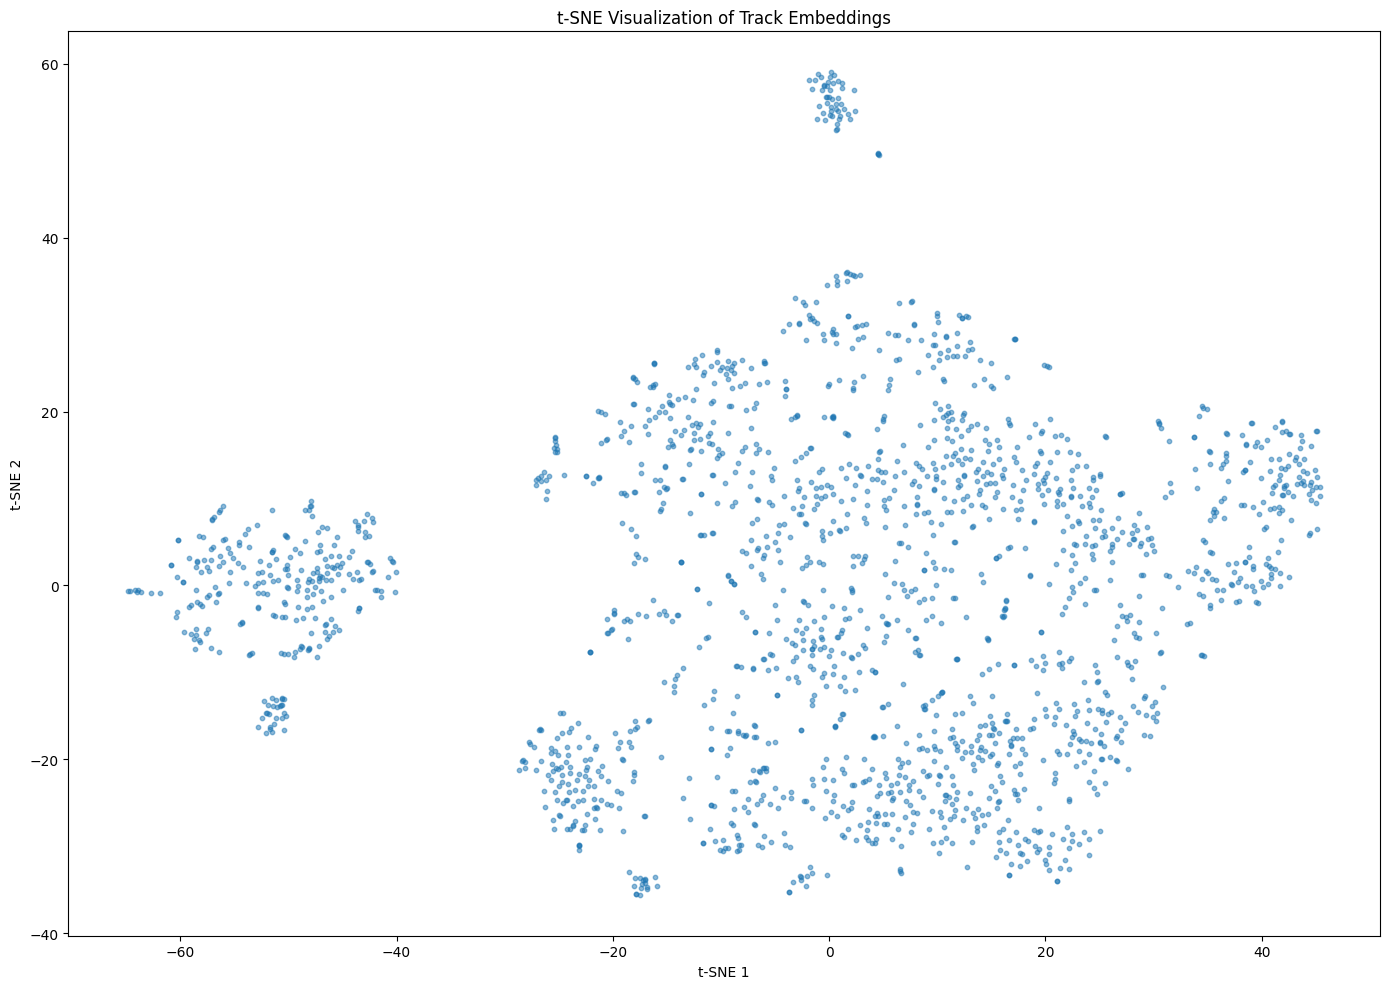

In [16]:
plt.figure(figsize=(14, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5, s=10)
plt.title('t-SNE Visualization of Track Embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.show()


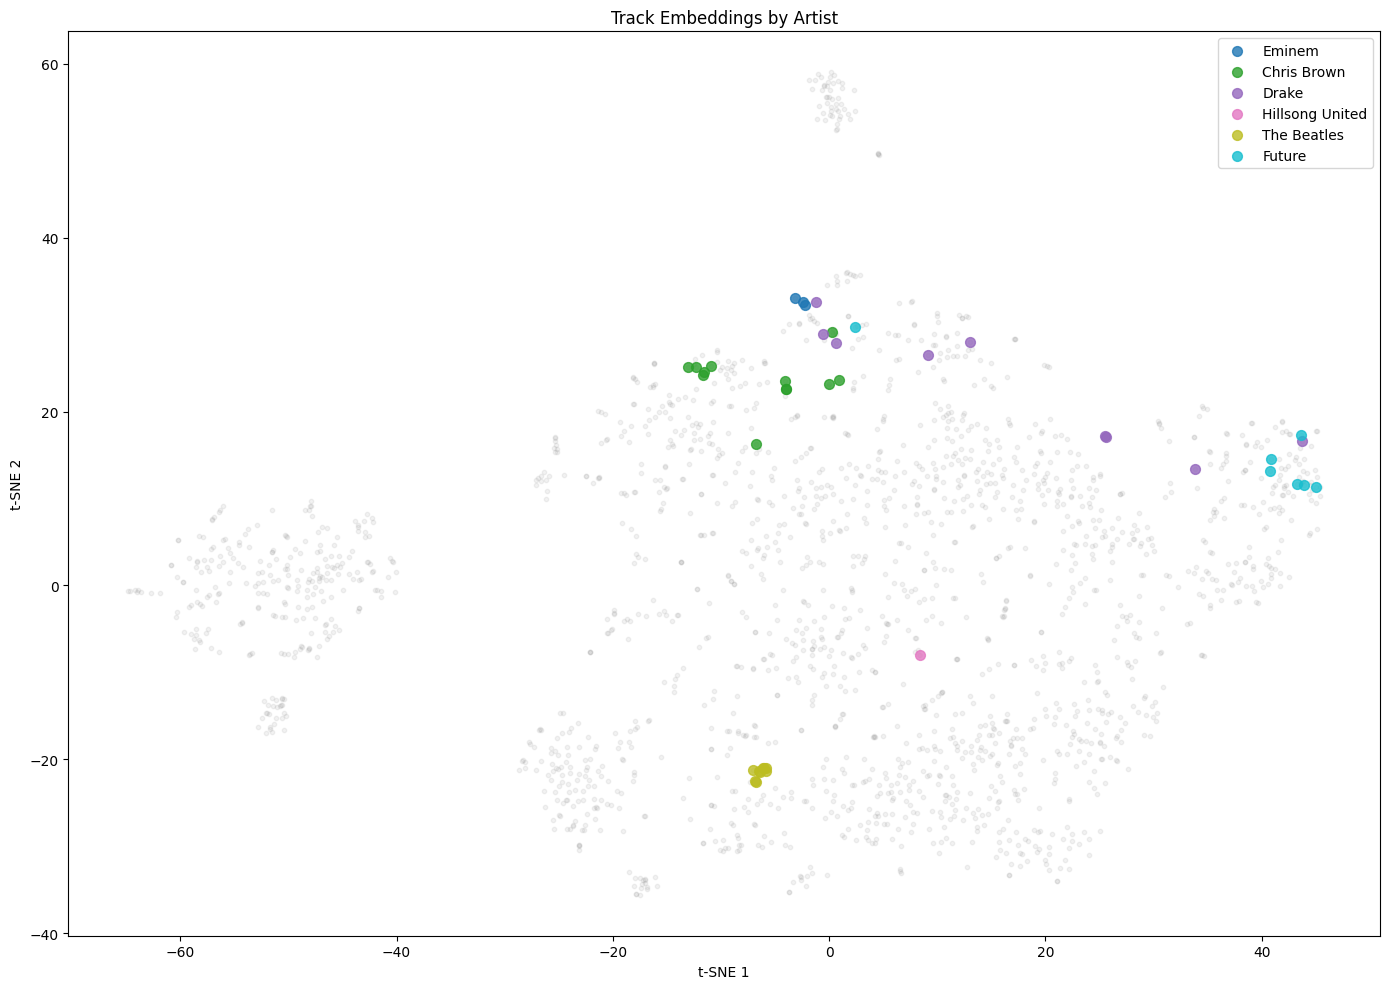

In [17]:
artists_to_highlight = top_artists[:6]
colors = plt.cm.tab10(np.linspace(0, 1, len(artists_to_highlight)))

plt.figure(figsize=(14, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.1, s=10, c='gray')

for artist, color in zip(artists_to_highlight, colors):
    artist_uris = set(artists_with_multiple[artist])
    indices = [i for i, uri in enumerate(top_uris) if uri in artist_uris]
    if indices:
        plt.scatter(
            embeddings_2d[indices, 0],
            embeddings_2d[indices, 1],
            alpha=0.8, s=50, c=[color], label=artist
        )

plt.legend(loc='upper right')
plt.title('Track Embeddings by Artist')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.show()


## Save Model


In [18]:
MODEL_DIR = Path("../models")
MODEL_DIR.mkdir(exist_ok=True)

model.save(str(MODEL_DIR / "track2vec.model"))
model.wv.save(str(MODEL_DIR / "track2vec.wordvectors"))

track_df.to_parquet(MODEL_DIR / "track_metadata.parquet", index=False)

print(f"Model saved to {MODEL_DIR}")
print(f"Files: {list(MODEL_DIR.glob('*'))}")


Model saved to ../models
Files: [PosixPath('../models/track2vec.model'), PosixPath('../models/.gitkeep'), PosixPath('../models/track_metadata.parquet'), PosixPath('../models/track2vec.wordvectors')]


## Quick Recommendation Function


In [19]:
def recommend_tracks(seed_tracks, topn=10, exclude_seeds=True):
    """
    Given a list of track URIs, recommend similar tracks.
    """
    valid_seeds = [t for t in seed_tracks if t in model.wv]
    if not valid_seeds:
        print("No valid seed tracks found in vocabulary")
        return pd.DataFrame()
    
    seed_vectors = [model.wv[t] for t in valid_seeds]
    centroid = np.mean(seed_vectors, axis=0)
    
    similar = model.wv.similar_by_vector(centroid, topn=topn + len(seed_tracks))
    
    results = []
    for uri, score in similar:
        if exclude_seeds and uri in seed_tracks:
            continue
        if len(results) >= topn:
            break
        results.append({
            'track': get_track_display(uri),
            'track_uri': uri,
            'similarity': round(score, 4)
        })
    return pd.DataFrame(results)


In [20]:
seed_playlist = playlist_sequences[0][:5]
print("Seed tracks:")
for uri in seed_playlist:
    print(f"  {get_track_display(uri)}")

print("\nRecommendations:")
recommend_tracks(seed_playlist, topn=10)


Seed tracks:
  Lose Control (feat. Ciara & Fat Man Scoop) - Missy Elliott
  Toxic - Britney Spears
  Crazy In Love - Beyoncé
  Rock Your Body - Justin Timberlake
  It Wasn't Me - Shaggy

Recommendations:


,track,track_uri,similarity
0,"1, 2 Step - Don Candiani Reggaeton Mix - Ciara",spotify:track:3x9LFpV6tzq0qWaBMvY2UT,0.9116
1,Shut Up - The Black Eyed Peas,spotify:track:3JILPb8Uc6NKmHq1poT5ML,0.8769
2,God Is a DJ - P!nk,spotify:track:2bvq7TmttrzDpw0i3U30te,0.8648
3,Pedestal - Fergie,spotify:track:4nh0td1DYne0vdfv3iKG9j,0.8584
4,"One, Two Step - Ciara",spotify:track:7uKcScNXuO3MWw6LowBjW1,0.8551
5,L.O.V.E. - Ashlee Simpson,spotify:track:7H2TYuu6OmqkxQD3LIZRC7,0.8516
6,Milkshake - Kelis,spotify:track:2cMTIlktg3M9mXYqCPqw1J,0.8512
7,Work It (feat. 50 Cent) - Remix - Missy Elliott,spotify:track:7Ml5yFM5H8gCQ4U4NSe4Bc,0.8499
8,Run the World (Girls) - Kaskade Club Remix - B...,spotify:track:5WMd5UjdS6FcdMl0mq4Y4I,0.8494
9,Pon de Replay - Rihanna,spotify:track:3U3Ff8ZvL6oEu1r98gCCWW,0.8468


# Run Personalized Recommendations

In [22]:
# Search for a song by name
def search_track(query):
    query = query.lower()
    matches = []
    for uri, info in track_info.items():
        if query in info['track_name'].lower() or query in info['artist_name'].lower():
            matches.append({
                'track': f"{info['track_name']} - {info['artist_name']}",
                'uri': uri,
                'in_vocab': uri in model.wv
            })
    return pd.DataFrame(matches[:20])

# Example: search for Drake songs
search_track("drake")

,track,uri,in_vocab
0,Portland - Drake,spotify:track:2bjwRfXMk4uRgOD9IBYl9h,True
1,Say Something (Featuring Drake) - Timbaland,spotify:track:49GYdiLjYMrUKr7H5YXHto,True
2,Preach - Drake,spotify:track:1OHoBC4icbuNhpSxP400sv,True
3,Headlines - Drake,spotify:track:6LxSe8YmdPxy095Ux6znaQ,True
4,Houstatlantavegas - Drake,spotify:track:0faYOYKrE2vel4dQQqgXkf,True
5,Runnin Away For Good - Drake,spotify:track:1rWatpQcBCiVIa1UhZAiyT,False
6,Things Behind The Sun - Nick Drake,spotify:track:7bIpR4tyHFgGLkue8fPLjL,False
7,Time Has Told Me - Nick Drake,spotify:track:1ltcsgH9qTWOB7MMwfvOeR,False
8,Road - Nick Drake,spotify:track:5USDPjFjBLfYF2G8UCbRpp,False
9,One Of These Things First - Nick Drake,spotify:track:24M81fKyhTWBuYzczQMkOp,True


In [27]:
# Find some tracks
print("=== Searching for 'one dance' ===")
display(search_track("one dance"))

print("\n=== Searching for 'starboy' ===")
display(search_track("starboy"))

=== Searching for 'one dance' ===


,track,uri,in_vocab
0,One Dance - Drake,spotify:track:1xznGGDReH1oQq0xzbwXa3,True
1,One Dance/Hasta El Amanecer - Mashup - Alex Aiono,spotify:track:2sFdE2HXR73kGRIAY7ItRM,True
2,One Dance - Jodi Benson,spotify:track:42zb6hCYgTYTf1HdnbaAw6,True
3,One Dance (feat. Harper) - Conor Maynard,spotify:track:0bsMTtWnxQ4lKlfBreueZt,True
4,One Dance - Broods,spotify:track:3EIc4WUSiaUQvBXgORwWM9,False
5,One Dance (feat. Casey Malone) - Koni,spotify:track:7c4r4RVkBQlWKy3D108Nnl,False
6,One Dance - William Singe,spotify:track:3VTw0oAbOy7CIKR8mbSBFV,True
7,What One Dance Can Do - Berres Hammond,spotify:track:3t09u1ohbli4mPPv5AyojQ,False
8,One Dance / Needed Me / Too Good (feat. Jaclyn...,spotify:track:06DVnefYLJ8rXRzsJcdujr,True
9,One Dance - Emie,spotify:track:04vOeYIdn9YqtBaFWtryOn,False



=== Searching for 'starboy' ===


,track,uri,in_vocab
0,Starboy - The Weeknd,spotify:track:5aAx2yezTd8zXrkmtKl66Z,True
1,Starboy - Kygo Remix - The Weeknd,spotify:track:6L778PA16SuyYvFhqnMndY,True
2,Starboy - Kurt Hugo Schneider,spotify:track:7wXknhAdpIl5GmNqwXRvnW,False
3,Starboy (Harder Better Faster Stronger Jersey ...,spotify:track:098BiO1QQzH1tMgSRS8eCz,False
4,Starboy (feat. Johannes Weber) - Koni,spotify:track:4PIu30DABi4r407Pxnmy0P,False
5,Starboy - Acoustic - Simon Samaeng,spotify:track:2QoyYV4YAuw9T9UgsDoam2,False
6,Starboy - Recorded at Spotify Studios NYC - SHAED,spotify:track:7FxWJX9m6V4d9lYZ5vogqW,False
7,Starboy - ESPRIT 空想,spotify:track:5oSKy0x7JWBpVZpZKhLgsy,False


In [24]:
my_seeds = [
    "spotify:track:1xznGGDReH1oQq0xzbwXa3",  # One Dance (example - use real URI)
    "spotify:track:7MXVkk9YMctZqd1Srtv4MB",  # Starboy (example - use real URI)
]
recommend_tracks(my_seeds, topn=10)

,track,track_uri,similarity
0,Too Good - Drake,spotify:track:11KJSRSgaDxqydKYiD2Jew,0.7553
1,Controlla - Drake,spotify:track:6F609ICg9Spjrw1epsAnpa,0.7365
2,Pop Style - Drake,spotify:track:5mPSyjLatqB00IkPqRlbTE,0.7200
3,Don't Mind - Kent Jones,spotify:track:27PmvZoffODNFW2p7ehZTQ,0.7001
4,Hype - Drake,spotify:track:5NFYuqu8V6QXc6mzcLImd6,0.6367
5,Panda - Desiigner,spotify:track:5OOkp4U9P9oL23maHFHL1h,0.6335
6,Work from Home - Fifth Harmony,spotify:track:4tCtwWceOPWzenK2HAIJSb,0.6274
7,Work - Bad Royale Remix - Rihanna,spotify:track:1FzbUxPXtF7q9M5Q7q49Gk,0.6224
8,Cheap Thrills - Sia,spotify:track:27SdWb2rFzO6GWiYDBTD9j,0.6210
9,This Is What You Came For - Calvin Harris,spotify:track:0azC730Exh71aQlOt9Zj3y,0.6181


# Recommendations for The Beatles

In [30]:
# Get Beatles tracks and their centroid
beatles_uris = set(artists_with_multiple.get("The Beatles", []))
print(f"Beatles tracks in vocabulary: {len(beatles_uris)}")

# Compute Beatles centroid
beatles_vectors = [model.wv[uri] for uri in beatles_uris if uri in model.wv]
beatles_centroid = np.mean(beatles_vectors, axis=0)

# Get MORE results so we can filter out Beatles
similar_to_beatles = model.wv.similar_by_vector(beatles_centroid, topn=100)

print("\nNon-Beatles tracks closest to The Beatles cluster:")
results = []
for uri, score in similar_to_beatles:
    if uri in beatles_uris:  # Skip Beatles tracks
        continue
    info = track_info.get(uri, {})
    results.append({
        'track': info.get('track_name', 'Unknown'),
        'artist': info.get('artist_name', 'Unknown'),
        'similarity': round(score, 4)
    })
    if len(results) >= 20:  # Stop after 20 non-Beatles tracks
        break

pd.DataFrame(results)

Beatles tracks in vocabulary: 130

Non-Beatles tracks closest to The Beatles cluster:


,track,artist,similarity
0,19th Nervous Breakdown - Remastered 2002,The Rolling Stones,0.9360
1,Easy - Music From The Motion Picture Baby Driver,Sky Ferreira,0.9215
2,This Guy's In Love With You,Herb Alpert & The Tijuana Brass,0.9179
3,Ruby Tuesday - Stereo Version,The Rolling Stones,0.9131
4,Mr. Tambourine Man,The Byrds,0.9123
5,Let It Be - Long Version,Carol Woods,0.9103
6,While My Guitar Gently Weeps - 2009 Digital Re...,George Harrison,0.9089
7,Keep On Running - Mono Version,The Spencer Davis Group,0.9087
8,My Generation - Live At The BBC 1965,The Who,0.9081
